In [1]:
import os
import cv2
import glob
import h5py
from scipy.io import loadmat
import numpy as np
from tqdm import tqdm
from utils import get_density_map_gaussian
import matplotlib.pyplot as plt
%matplotlib inline


with_direction = False

C:\Users\asus\anaconda3\envs\csrnet_kb\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\asus\anaconda3\envs\csrnet_kb\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\asus\anaconda3\envs\csrnet_kb\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\asus\anaconda3\envs\csrnet_kb\lib\site-packages\tensorf

In [2]:
root = 'data/ShanghaiTech/'

In [3]:
part_A_train = os.path.join(root, 'part_A/train_data', 'images')
part_A_test = os.path.join(root, 'part_A/test_data', 'images')
part_B_train = os.path.join(root, 'part_B/train_data', 'images')
part_B_test = os.path.join(root, 'part_B/test_data', 'images')
path_sets_A = [part_A_train, part_A_test]
path_sets_B = [part_B_train, part_B_test]

In [4]:
img_paths_A = []
for path in path_sets_A:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths_A.append(img_path)
print(len(img_paths_A))
img_paths_B = []
for path in path_sets_B:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths_B.append(img_path)
print(len(img_paths_B))

40
40


In [5]:
for part in ['A', 'B']:
    for t in ['train', 'test']:
        if not os.path.exists('data/ShanghaiTech/part_{}/{}_data/ground/'.format(part, t)):
            os.mkdir('data/ShanghaiTech/part_{}/{}_data/ground/'.format(part, t))
templates = []
for i in sorted(glob.glob(os.path.join('data', '*.npy')), key=lambda x: int(x.split('/')[-1].split('.')[0])):
    templates.append(np.load(i))
for dataset in ['B', 'A']:
    img_paths = eval('img_paths_'+dataset)
    if dataset == 'A':
        is_adaptive = True
    else:
        is_adaptive = False
    for img_path in tqdm(img_paths):

        pts = loadmat(img_path.replace('.jpg', '.mat').replace('images', 'ground-truth').replace('IMG_', 'GT_IMG_'))
        img = cv2.imread(img_path)

        k = np.zeros((img.shape[0], img.shape[1]))

        gt = pts["image_info"][0, 0][0, 0][0] - 1

        for i in range(len(gt)):
            if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:
                k[int(gt[i][1]), int(gt[i][0])] = 1

        k = get_density_map_gaussian(
            k, gt, adaptive_mode=is_adaptive
        )

        file_path = img_path.replace('.jpg', '.h5').replace('images', 'ground')

        with h5py.File(file_path, 'w') as hf:
            hf['density'] = k

100%|██████████| 40/40 [00:08<00:00,  4.60it/s]


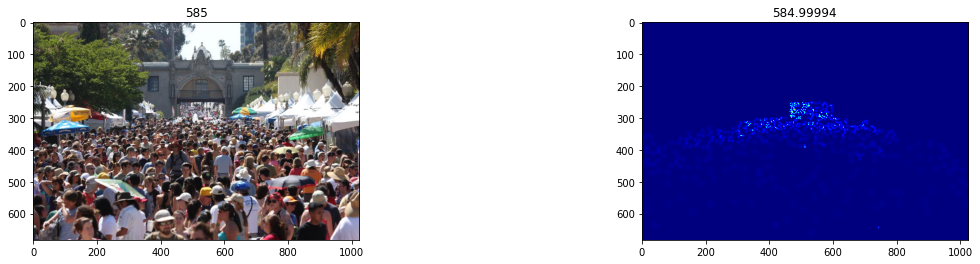

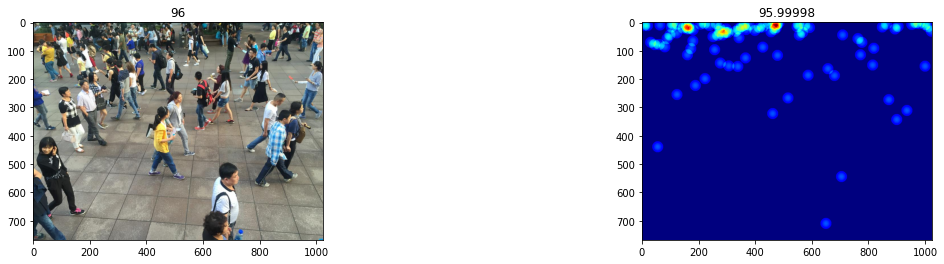

In [7]:
# Show a sample
img_paths = ['data/ShanghaiTech/part_A/train_data/images/IMG_5.jpg',
             'data/ShanghaiTech/part_B/train_data/images/IMG_5.jpg']
from utils import load_img
is_adaptive = False
for img_path in img_paths:
    is_adaptive = not is_adaptive
    img_ori = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    pts = loadmat(img_path.replace('.jpg', '.mat').replace('images', 'ground-truth').replace('IMG_', 'GT_IMG_'))
    img = cv2.imread(img_path)

    k = np.zeros((img.shape[0], img.shape[1]))

    gt = pts["image_info"][0, 0][0, 0][0]

    for i in range(len(gt)):
        if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:
            k[int(gt[i][1]), int(gt[i][0])] = 1

    k = get_density_map_gaussian(k, gt, adaptive_mode=is_adaptive)

    fg, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 4))
    ax0.imshow(img_ori)
    ax0.set_title(str(gt.shape[0]))
    ax1.imshow(np.squeeze(k), cmap=plt.cm.jet)
    ax1.set_title(str(np.sum(k)))
    plt.show()